<a href="https://colab.research.google.com/github/ZdjelarFilip/Dijaski.net_strojno_ucenje/blob/main/ML_Dija%C5%A1ki.net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJEKT - Analiza in strojno učenje nad podatki na spletnem mestu Dijaški.net**

Namen naslednjega projekta je analiziranje podatkov vpisnih mest na fakultetah preko podatkov, ki so pridobljeni s strani Dijaški.net. V projektu bomo v prvem poglavju predstavili problem s katerim se soočamo, nato pa bomo predstavili postopek pridobitve podatkov. Sledi segment o čiščenju, pripravi in obdelavi podatkov, saj v originalni obliki podatki niso primerni za namen strojnega učenja in potrebujejo predprocesiranje. Preostane še pomembno poglavje o izvajanju strojnega učenja, na samem koncu pa bomo povzeli pomembne ugotovitve.

# 1. Problem

Spletni portal **Dijaški.net** predstavlja vodilno slovensko stran, ki želi na kar najbolj učinkoviti način pomagati srednješolcem pri odločitvi za nadaljnji študij. Vsebuje številna gradiva, iskalnik študijskih programov za visoke šole in fakultete kot tudi omejitve vpisa za posamezne študije.

V sklopu projekta nas predvsem zanima struktura fakultet na slovenskem, kjer želimo izvedeti, kakšno je razmerje med prevladujočimi univerzami glede števila vpisov. Zanima nas, ali se generacije čez leta povečujejo ali padajo ter kakšno je stanje glede klasifikacije smeri. Obenem želimo izvedeti ali obstajajo kakšne povezave med generacijami. Navsezadnje pa želimo napovedati število vpisnih mest za prihajajoče generacije ter primerjati napovedane rezultate z dejanskimi.

# 2. Pridobitev podatkov

Iskanje podatkov za vpisna mesta vsake posamezne fakultete je precej zamudno delo, smo si to olajšali z izdelavo programa (*pajka*) za spletno strganje, ki pridobi pomembne podatke za vsak visokošolski študijski program za vsako posamezno univerzo v Sloveniji. Program v spodnjem odseku kode iterira skozi vsako univerzo na portalu *Dijaški.net* in v sklopu vsake fakultete izpiše unikatne programe ter shrani sledeče podatke v *csv* datoteko:
- **univerza**, ki predstavlja univerzo (npr. *Univerza v Novi Gorici*)
- **fakulteta**, ki predstavlja fakulteto (npr. *Fakulteta za humanistiko*)
- **program**, ki predstavlja naziv študijskega programa (npr. *Slovenistika*)
- **st_leto**, ki predstavlja študijsko leto (npr. *2022/23*)
- **rok**, ki predstavlja vpisni rok (vrednost *1.* predstavlja prvi-*poletni* vpisni rok, vrednost *2.* predstavlja drugi-*jesenski* vpisni rok)
- **razpis**, ki predstavlja število razpisanih mest za program (npr. številska vrednost *60*)
- **prijave** , ki predstavlja število prijavljenih študentov na program (npr. številska vrednost *60*)
- **sprejeti**, ki predstavlja število sprejetih študentov v program (npr. številska vrednost *60* )
- **omejitev**, ki predstavlja minimalno število potrebnih točk za vpis na študij (npr. številska vrednost *60*, v nekaterih primerih pa tudi *Brez omejitve*)

In [ ]:
!pip install Scrapy

In [ ]:
# Opomba - program je bil pognan v PyCharm-u s pomočjo Anaconde, zato ni prikazanega izpisa na colab platformi 

import scrapy

class Spider1(scrapy.Spider):
        name = 'dijaski_spider'
        allowed_domains = ['dijaski.net']
        FEED_EXPORT_ENCODING = 'utf-8'

        def start_requests(self):
            urls = ['https://dijaski.net/studij/visokosolski-studij']
            print(urls)
            for url in urls:
                yield scrapy.Request(url=url, callback=self.parse_glavna_stran)

        def parse_glavna_stran(self, response: scrapy.Request):            
            vse_univerze = {
                'https://dijaski.net/studij/ul',
                'https://dijaski.net/studij/um',
                'https://dijaski.net/studij/up',
                'https://dijaski.net/studij/unm',
                'https://dijaski.net/studij/ung',
                'https://dijaski.net/studij/nu',
                'https://dijaski.net/studij/visokosolski-zavodi'
            }
            for url_univerze in vse_univerze:
                yield scrapy.Request(url=url_univerze, callback=self.parse_institucije)

        def parse_institucije(self, response: scrapy.Request):
            vse_institucije = response.css('.media-middle::attr(href)').extract()
            for institucija in vse_institucije:
                url_institucije = 'https://dijaski.net' + institucija
                print(url_institucije)
                yield scrapy.Request(url=url_institucije, callback=self.parse_institucijeProgram)

        def parse_institucijeProgram(self, response: scrapy.Request):
            vsi_programi = response.css('.media-middle::attr(href)').extract()

            for institucija in vsi_programi:
                url_programa = 'https://dijaski.net' + institucija
                print(url_programa)
                yield scrapy.Request(url=url_programa, callback=self.parse_vrednosti)

        def parse_vrednosti(self, response: scrapy.Request):
            vrednosti = response.css('.list-inline')
            for vrednost in vrednosti:
                vrednosti_tabela = {}
                vrednosti_tabela['univerza'] = response.css('ol > li:nth-child(3) > a > span[property="name"]::text').extract()
                vrednosti_tabela['fakulteta'] = response.css('ol > li:nth-child(4) > a > span[property="name"]::text').extract()
                vrednosti_tabela['program'] = response.css('ol > li:nth-child(5) > span[property="item"]::text').extract()
                vrednostiTbl= response.xpath('//*[@class="table table-responsive table-bordered xs-padding"]//tbody//tr')

                for row in vrednostiTbl:
                    vrednosti_tabela['st_leto'] = row.xpath('td[1]//text()').extract_first(),
                    vrednosti_tabela['rok'] = row.xpath('td[2]//text()').extract_first(),
                    vrednosti_tabela['razpis'] = row.xpath('td[3]//text()').extract_first(),
                    vrednosti_tabela['prijave'] = row.xpath('td[4]//text()').extract_first(),
                    vrednosti_tabela['sprejeti'] = row.xpath('td[5]//text()').extract_first(),
                    vrednosti_tabela['omejitev'] = row.xpath('td[6]//text()').extract_first()
                    yield vrednosti_tabela

# 3. Predprocesiranje in analiza podatkov

V prihajajočem poglavju bomo predstavili potrebno predprocesiranje podatkov, ki nam bo pomagalo prečistiti podatke in jih spraviti v primerno obliko za strojno učenje.

Skozi celoten projekt bomo uporabljali sledeči *pandas* in *numpy* knjižnjici za obdelavo in manipuliranje s podatki.

In [ ]:
import pandas as pd
import numpy as np

Sprva je potrebno naložiti zbrane podatke, da bomo lahko nad njimi izvajali manipulacijo in preobrazbo.

In [ ]:
df = pd.read_excel('/content/DijaskiNetData.xlsx', dtype = object)

df.head()

,univerza,fakulteta,program,st_leto,rok,razpis,prijave,sprejeti,omejitev
0,Univerza v Ljubljani,Akademija za glasbo,Glasbena umetnost,2022/23,1,60,115,53,Omejitev
1,Univerza v Ljubljani,Akademija za glasbo,Glasbena umetnost,2022/23,2,6,5,/,
2,Univerza v Ljubljani,Akademija za glasbo,Glasbena umetnost,2021/22,1,60,152,57,Omejitev
3,Univerza v Ljubljani,Akademija za glasbo,Glasbena umetnost,2021/22,2,10,14,7,Omejitev
4,Univerza v Ljubljani,Akademija za glasbo,Glasbena umetnost,2020/21,1,60,158,60,"Omejitev, minimum je 57,65"


Potrebno je preveriti, ali številski stolpci vsebujejo samo številske vrednosti. V nasprotnem primeru bo potrebna nadaljnja obdelava v primeren format.

In [ ]:
def is_not_digit(string):
    return not string.isdigit()

columns = ['sprejeti', 'prijave', 'razpis', 'rok']
not_digits = {col: sum(df[col].apply(is_not_digit)) for col in columns}

for col, not_digit in not_digits.items():
    print(f"Število neštevilčnih vrednosti v tabeli {col}: {not_digit}")
    unique_non_numeric_elements = df[df[col].apply(is_not_digit)][col].unique()
    print(f"Unikatne neštevilčne vrednosti v tabeli {col}: {unique_non_numeric_elements}")

Število neštevilčnih vrednosti v tabeli sprejeti: 14231
Unikatne neštevilčne vrednosti v tabeli sprejeti: ['/' '(None,)']
Število neštevilčnih vrednosti v tabeli prijave: 11417
Unikatne neštevilčne vrednosti v tabeli prijave: ['/' '(None,)']
Število neštevilčnih vrednosti v tabeli razpis: 3416
Unikatne neštevilčne vrednosti v tabeli razpis: ['(None,)' '/']
Število neštevilčnih vrednosti v tabeli rok: 3395
Unikatne neštevilčne vrednosti v tabeli rok: ['(None,)']


Obenem pa nas je zanimala tudi količina unikatnih rokov v sklopu podatkov, kjer smo ugotovili da sta prevladujoča 1. in 2., 3. pa vsebuje zgolj kopico nenatančnih in ne-zanesljivih vrednosti.

In [ ]:
counts = df['rok'].value_counts()
print(counts)

1          30576
2          18263
(None,)     3395
3           1547
Name: rok, dtype: int64


V podatkih smo zasledili veliko količino nepopolnih vrednosti, ki so označene z znakom */* ali *(None,)* , zato jih bomo odstranili. Obenem pa so v stolpcu *omejitev* dvoumni in kontradiktorni podatki, zato ga ne bomo upoštevali.

In [ ]:
dfToClean = df[['razpis', 'prijave', 'sprejeti', 'rok']]

# Zbrišemo podatke, kjer ni numberične vrednosti (kot npr. znak '/')
df_filtered = dfToClean[~dfToClean[['razpis', 'prijave', 'sprejeti', 'rok']].apply(pd.to_numeric, errors='coerce').notnull().all(axis=1)]

if 'omejitev' in df.columns:
  df = df.drop(columns=['omejitev'])

df.drop(index = df_filtered.index, inplace = True)

df = df.drop_duplicates(subset=['fakulteta','univerza','program','st_leto','rok'], keep='first')

df.describe()

,univerza,fakulteta,program,st_leto,rok,razpis,prijave,sprejeti
count,4059,4059,4059,4059,4059,4059,4059,4059
unique,7,68,284,15,3,120,307,184
top,Univerza v Ljubljani,Filozofska fakulteta,Zdravstvena nega,2020/21,1,30,1,2
freq,2293,735,65,543,2468,318,183,253


Ker ob strganju podatkov iz spletnih mest nismo pridobili informacije o klasifikaciji fakultet, smo jih generirali sami s pomočjo seznamov ključnih besed, ki so značilne za posamezen sklop univerz in programov. Če se je besedilo v stolpcu univerz, fakultet ali programov ujemalo z nizom podatkov, značilnih za vsak posamezen sklop fakultet, smo pripadajoči entiteti dodelili ustrezno klasifikacijo.

In [ ]:
substringsUmetniska = ['medije','dizajn','multimedij','iam','likovn','tekstil','glas','ples','vokal','umetnost', 'dramska igra',
                       'likovno','oblikovanj','radio','film','televizija','gledališ','slik','ilustrac','vizualnih komunik','kiparstvo']
                       
substringsZdravstvena = ['medicinska','treniran','zdrav', 'fizio', 'kozmet', 'šport', 'vist']

substringsNaravoslovna = ['farmacija','okolje','geografij','varstvoslovje','pomorstvo','geodez','pomorstvo','energet','vinograd','b&b',
                          'kemij','okolja','veterin','teološka','naravosl', 'bio', 'matemat', 'fizik', 'narav', 'turiz']

substringsDruzboslovna = ['državne in evropske štu','management','italijan','komuniciranje in mediji','management','humanistični','policijsk',
                          'management poslovnih','arema','aerma','turistica','humanis','varnost','b2','organizacijske','poslovne vede','podjetništ',
                          'mlc','pravo','filozofska fakulteta','rusol','prevajalstv','razredni','jezik','špan','azijske','primerjaln','slovak',
                          'slovan','predšolsk','zgodovin','pedago', 'družbene', 'uprav', 'filo', 'sloven', 'mednarod', 'social', 'mediji in novin']

substringsTehniska = ['inženiring','informacijska varnost','industrijski inžen','arhitekt','spletne in','logistik','gradben','proizvodno inž','račun',
                      'informat', 'elektro','ekonom', 'stroj']

# Vsem besedam smo spremenili znake iz velikih v male črke za lažjo primerjavo
df = df.apply(lambda x: x.astype(str).str.lower() if x.dtype == "object" else x)

def check_programi(row):
    categories = {
        'Umetniska': substringsUmetniska,
        'Zdravstvena': substringsZdravstvena,
        'Naravoslovna': substringsNaravoslovna,
        'Druzboslovna': substringsDruzboslovna,
        'Tehniska': substringsTehniska
    }
    for category, substrings in categories.items():
        if any(substring in row['univerza'] for substring in substrings) or \
           any(substring in row['program'] for substring in substrings) or \
           any(substring in row['fakulteta'] for substring in substrings):
            return category

df['klasifikacija_fakultete'] = df.apply(check_programi, axis=1)
df['klasifikacija_fakultete'].value_counts()

# Preverjanje če je preostala nedodeljena klasifikacija
df_null = df.loc[df['klasifikacija_fakultete'].isnull()]
df_distinct = df_null.drop_duplicates(subset=['program'])

Sedaj pa imamo pogled nad generalno statistiko za trenutno obdelane podatke:
- Vse skupaj imamo *4059* zapisov o vpisnih podatkih za fakultete,
- Največ vpisnih podatkov smo pridobili za *Univerzo v Ljubljani*
- Med najpogostejšimi fakultetami se pojavi *Filozofska fakulteta*, vendar pa je kot zanimivost največji delež programov s strani *zdravstvene nege*.
- Največja količina podatkov je v generaciji *2020/21*
- Najbolj popularna klasifikacija fakultete pa je *Družboslovna*

In [ ]:
df.describe()

,univerza,fakulteta,program,st_leto,rok,razpis,prijave,sprejeti,klasifikacija_fakultete
count,4059,4059,4059,4059,4059,4059,4059,4059,4059
unique,7,68,284,15,3,120,307,184,5
top,univerza v ljubljani,filozofska fakulteta,zdravstvena nega,2020/21,1,30,1,2,Druzboslovna
freq,2293,735,65,543,2468,318,183,253,1467


V sklopu analize je še potrebno preveriti velikost posameznih generacij. V spodnjih grafih lahko vidimo primerjavo med neočiščenim in očiščenim grafom glede na velikost števila vpisanih na vsako generacijo. Obdržali smo generacije od leta 2016/17 do 2021/22, saj vsebujejo primerno število podatkov za nadaljnjo analizo, preostale generacije pa smo ovrgli zaradi pomanjkljivega števila parametrov.

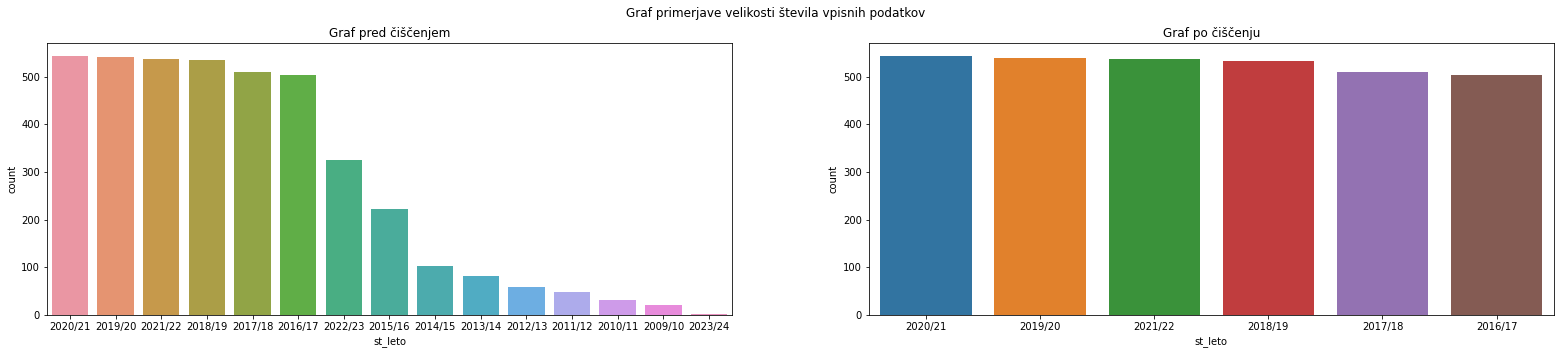

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(27, 5))

# Prvi(levi) neprečiščen graf
sns.countplot(x='st_leto', data=df, order=pd.value_counts(df['st_leto']).index, ax=ax1)
ax1.set_title("Graf pred čiščenjem")

df = df[~df['st_leto'].isin(['2015/16', '2014/15', '2013/14', '2012/13', '2011/12', '2010/11', '2009/10', '2023/24', '2022/23'])]
df = df[~df['rok'].isin(['3'])]

# Drugi(desni) prečiščen graf
sns.countplot(x='st_leto', data=df, order=pd.value_counts(df['st_leto']).index, ax=ax2)
ax2.set_title("Graf po čiščenju")

fig.suptitle("Graf primerjave velikosti števila vpisnih podatkov")
fig.show()

Ugotovili smo, da največji delež zaseda *Ljubljanska univerza*, tik za njo pa *Mariborska*. Preostanek univerz si lasti bistveno nižji odstoten delež.

Presenetil nas je tudi podatek, da največji delež klasifikacije fakultet pripada namreč *družboslovni smeri*, najmanjši delež pa *zdravstveni*.

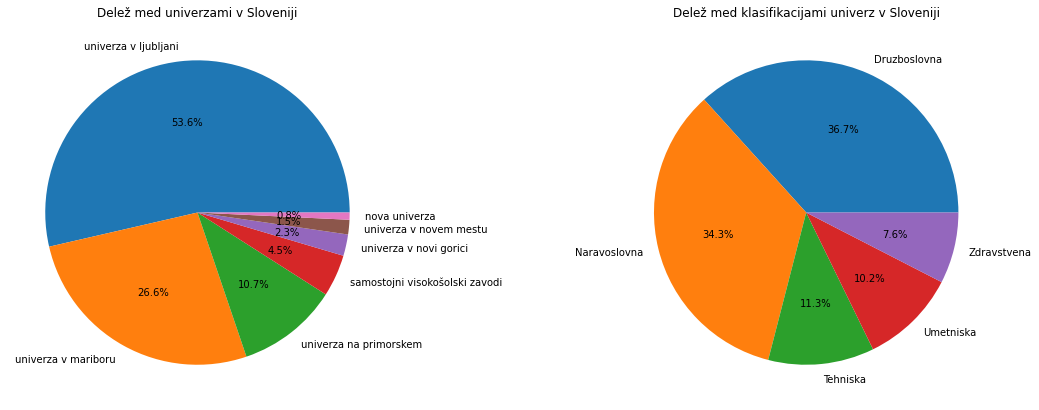

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Prvi(levi) graf
df_pie1 = df['univerza'].value_counts()
ax[0].pie(df_pie1.values, labels=df_pie1.index, autopct='%1.1f%%')
ax[0].set_title('Delež med univerzami v Sloveniji')

# Prvi(desni) graf
df_pie2 = df['klasifikacija_fakultete'].value_counts()
ax[1].pie(df_pie2.values, labels=df_pie2.index, autopct='%1.1f%%')
ax[1].set_title('Delež med klasifikacijami univerz v Sloveniji')

plt.show()

Izvedli smo analizo za število razpisanih, prijavljenih in sprejetih mest za celotno zbirko podatkov v preteklih 6 letih. Ugotovili smo, da je delež razpisanih manjši kot število prijavljenih študentov, delež za sprejeta mesta pa je kot pričakovano najmanjši.

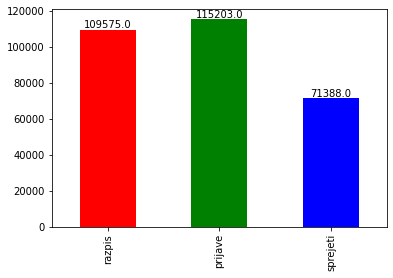

In [ ]:
df[['razpis', 'prijave', 'sprejeti']] = df[['razpis', 'prijave', 'sprejeti']].astype(float)

max_values = df[['razpis','prijave','sprejeti']].sum()

ax = max_values.plot.bar(color=['red', 'green', 'blue'])

for i, bar in enumerate(ax.patches):
    x_pos = bar.get_x() + bar.get_width()/2
    y_pos = bar.get_height()
    count = np.round(y_pos, 2)
    ax.text(x_pos, y_pos, count, ha='center', va='bottom')

plt.show()

Za nadaljnje prečiščevanje podatkov smo ustvarili nekaj novih stolpcev v tabeli, ki bodo služili za lažjo preslikavo podatkov v grafično obliko. Ustvarili smo tabele, ki temeljijo na osnovi:
- odstotka sprejetih študentov glede na razpis/prijave
- velikosti generacije glede na prijave/razpis/sprejete študente
- velikosti generacije za vsako posamezno klasifikacijo glede na prijave/razpis/sprejete študente  

In [ ]:
df['odstotek_sprejetih_glede_na_razpis'] = df.apply(lambda row: 100 * row['sprejeti'] / row['razpis'] if row['razpis'] != 0 else 0, axis=1)
df['odstotek_sprejetih_glede_na_prijave'] = df.apply(lambda row: 100 * row['sprejeti'] / row['prijave'] if row['prijave'] != 0 else 0, axis=1)

df['velikost_generacije_glede_na_prijave'] = df.groupby(['st_leto', 'rok'])['prijave'].transform('sum')
df['velikost_generacije_glede_na_razpis'] = df.groupby(['st_leto', 'rok'])['razpis'].transform('sum')
df['velikost_generacije_glede_na_sprejete'] = df.groupby(['st_leto', 'rok'])['sprejeti'].transform('sum')

df['velikost_generacije_za_klasifikacijo_glede_na_prijave'] = df.groupby(['st_leto', 'rok', 'klasifikacija_fakultete'])['prijave'].transform('sum')
df['velikost_generacije_za_klasifikacijo_glede_na_razpis'] = df.groupby(['st_leto', 'rok', 'klasifikacija_fakultete'])['razpis'].transform('sum')
df['velikost_generacije_za_klasifikacijo_glede_na_sprejete'] = df.groupby(['st_leto', 'rok', 'klasifikacija_fakultete'])['sprejeti'].transform('sum')

Spodaj imamo pregled nad velikostijo generacij glede na prijavo, razpis in sprejete študente. Kot pričakovano je v 1. roku vsake generacije večji delež študentov kot v 2. roku, ki je pretežno namenjen zamudnikom, ki so maturo opravljali kasneje. Presenetila nas je zgolj vrednost za 1. rok 2021/22 generacije, ki je skoraj 2x večja kot običajno. V kolikor pa gledamo celotno sliko, se izkaže, da so porasti pri prijavah in sprejemu študentov, stanje velikosti razpisov pa rahlo stagnira.

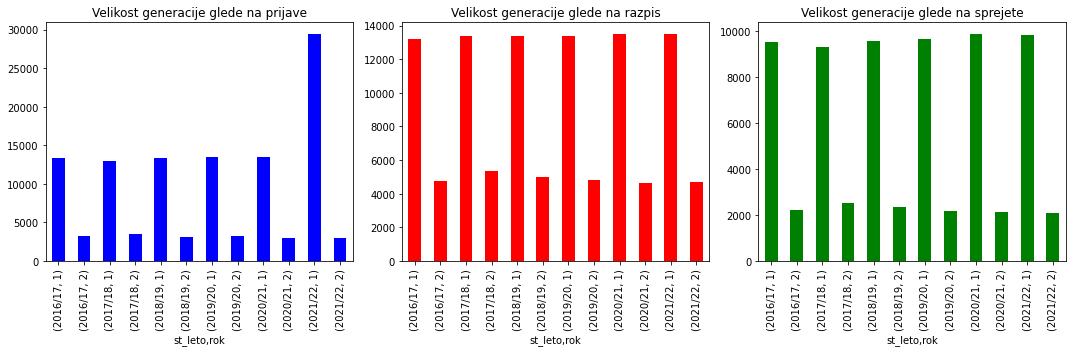

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df.groupby(['st_leto', 'rok'])['prijave'].sum().plot.bar(ax=ax[0], color='blue', title='Velikost generacije glede na prijave')
df.groupby(['st_leto', 'rok'])['razpis'].sum().plot.bar(ax=ax[1], color='red', title='Velikost generacije glede na razpis')
df.groupby(['st_leto', 'rok'])['sprejeti'].sum().plot.bar(ax=ax[2], color='green', title='Velikost generacije glede na sprejete')
plt.tight_layout()
plt.show()

Ker nas je podatek nad 2x večjim številom prijav v letu 2021/22 presenetil, smo želeli izvedeti zakaj. Na podlagi številnih analiz pa lahko zgolj sklepamo, da so podatki res pravilni in zanesljivi.

In [ ]:
df_grouped = df.groupby('st_leto').sum()
df_grouped_prijave = df.groupby('st_leto')['prijave'].mean().reset_index()

print("Values for df_grouped:")
print(df_grouped)

print("Values for df_grouped_prijave:")
print(df_grouped_prijave)

Values for df_grouped:
          razpis  prijave  sprejeti  odstotek_sprejetih_glede_na_razpis  \
st_leto                                                                   
2016/17  17978.0  16589.0   11798.0                        30370.231195   
2017/18  18692.0  16389.0   11880.0                        29687.440177   
2018/19  18403.0  16526.0   11912.0                        30638.429014   
2019/20  18187.0  16734.0   11865.0                        30491.547120   
2020/21  18109.0  16545.0   12019.0                        31959.713370   
2021/22  18206.0  32420.0   11914.0                        31190.926517   

         odstotek_sprejetih_glede_na_prijave  \
st_leto                                        
2016/17                         41230.251039   
2017/18                         42444.534520   
2018/19                         44138.967313   
2019/20                         41708.888016   
2020/21                         44275.390538   
2021/22                         30953.45

Izvedli smo tudi analizo nad maksimalno velikost najbolj reprezentativnih generacij glede na prijave, razpis in sprejete študente. Presenetilo nas je dejstvo, da je v vsakem izmed grafov prisoten družbosloven študij.

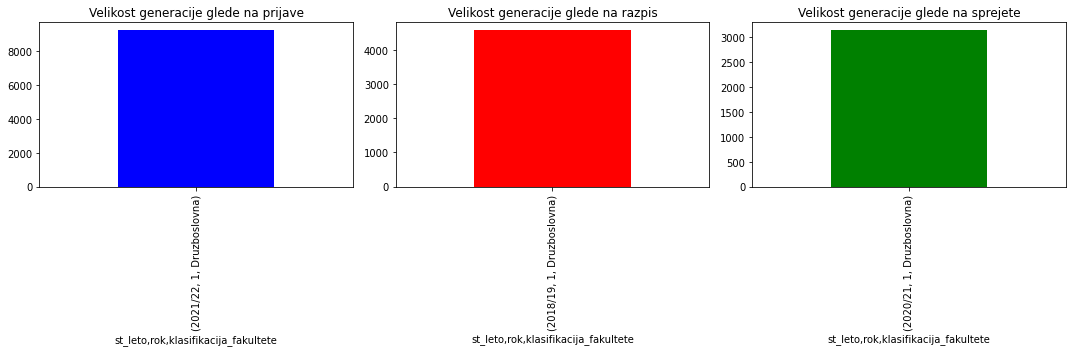

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df.loc[df['velikost_generacije_za_klasifikacijo_glede_na_prijave'] == df['velikost_generacije_za_klasifikacijo_glede_na_prijave'].max()].groupby(['st_leto', 'rok', 'klasifikacija_fakultete'])['prijave'].sum().plot.bar(ax=ax[0], color='blue', title='Velikost generacije glede na prijave')
df.loc[df['velikost_generacije_za_klasifikacijo_glede_na_razpis'] == df['velikost_generacije_za_klasifikacijo_glede_na_razpis'].max()].groupby(['st_leto', 'rok', 'klasifikacija_fakultete'])['razpis'].sum().plot.bar(ax=ax[1], color='red', title='Velikost generacije glede na razpis')
df.loc[df['velikost_generacije_za_klasifikacijo_glede_na_sprejete'] == df['velikost_generacije_za_klasifikacijo_glede_na_sprejete'].max()].groupby(['st_leto', 'rok', 'klasifikacija_fakultete'])['sprejeti'].sum().plot.bar(ax=ax[2], color='green', title='Velikost generacije glede na sprejete')
plt.tight_layout()
plt.show()

Predstavljeno pa še imamo najmanjšo velikost generacije glede na prijave, razpis in sprejete študente, kjer se je kot poglavitna klasifikacija izkazala *umetniška klasifikacija* z ekstremno nizkimi vrednostmi. 

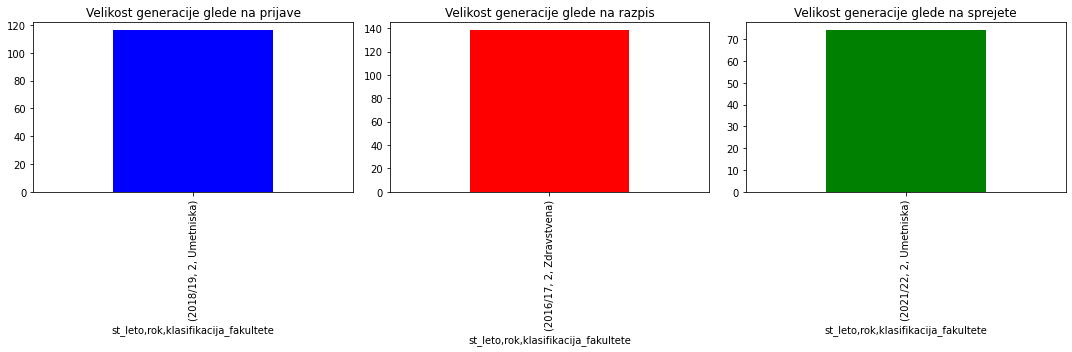

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df.loc[df['velikost_generacije_za_klasifikacijo_glede_na_prijave'] == df['velikost_generacije_za_klasifikacijo_glede_na_prijave'].min()].groupby(['st_leto', 'rok', 'klasifikacija_fakultete'])['prijave'].sum().plot.bar(ax=ax[0], color='blue', title='Velikost generacije glede na prijave')
df.loc[df['velikost_generacije_za_klasifikacijo_glede_na_razpis'] == df['velikost_generacije_za_klasifikacijo_glede_na_razpis'].min()].groupby(['st_leto', 'rok', 'klasifikacija_fakultete'])['razpis'].sum().plot.bar(ax=ax[1], color='red', title='Velikost generacije glede na razpis')
df.loc[df['velikost_generacije_za_klasifikacijo_glede_na_sprejete'] == df['velikost_generacije_za_klasifikacijo_glede_na_sprejete'].min()].groupby(['st_leto', 'rok', 'klasifikacija_fakultete'])['sprejeti'].sum().plot.bar(ax=ax[2], color='green', title='Velikost generacije glede na sprejete')
plt.tight_layout()
plt.show()


Pri deležu vpisnih podatkov za vsak rok je reprezentativen 1. (rok), takoj za njim pa mu sledi 2.

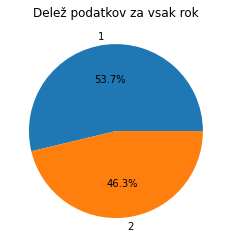

In [ ]:
import matplotlib.pyplot as plt

rok_counts = df['rok'].value_counts().to_dict()

plt.pie(rok_counts.values(), labels=rok_counts.keys(), autopct='%1.1f%%')
plt.title("Delež podatkov za vsak rok")
plt.show()

Spodaj pa imamo vizualni prikaz programov na 1. in 2. roku, ki so ločeni glede na količino razpisanih mest. Opazimo lahko, da so razpisana mesta za 2. rok bistveno nižja kot za 1.

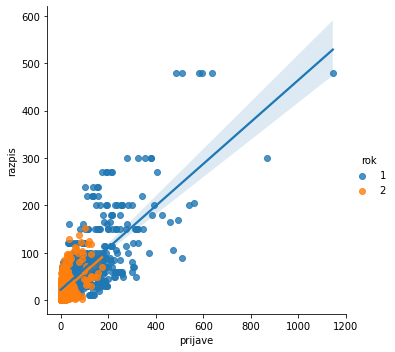

In [ ]:
import seaborn as sns

sns.lmplot(x='prijave', y='razpis', data=df,
          fit_reg=True, # Brez črte povezave med spremenljivkama
          hue='rok') # Barva pike glede na regijo

V sklopu deleža prijav na fakultete smo ugotovili, da se med top 5 najbolj prijavljenimi pojavijo *filozofska*, *pedagoška*, *ekonomska*, *zdravstvena* in *biotehniška*. 

V sklopu deleža najmanj prijavljenih fakultet pa se pojavi *fakulteta za naravoslovje*, *fakulteta za znanosti o okolju*, *fakulteta za humanistiko*, *visoka šola za proizvodno inžinirstvo*, na zadnjem mestu brez prijav pa je *fakulteta za poslovne in upravne vede*.

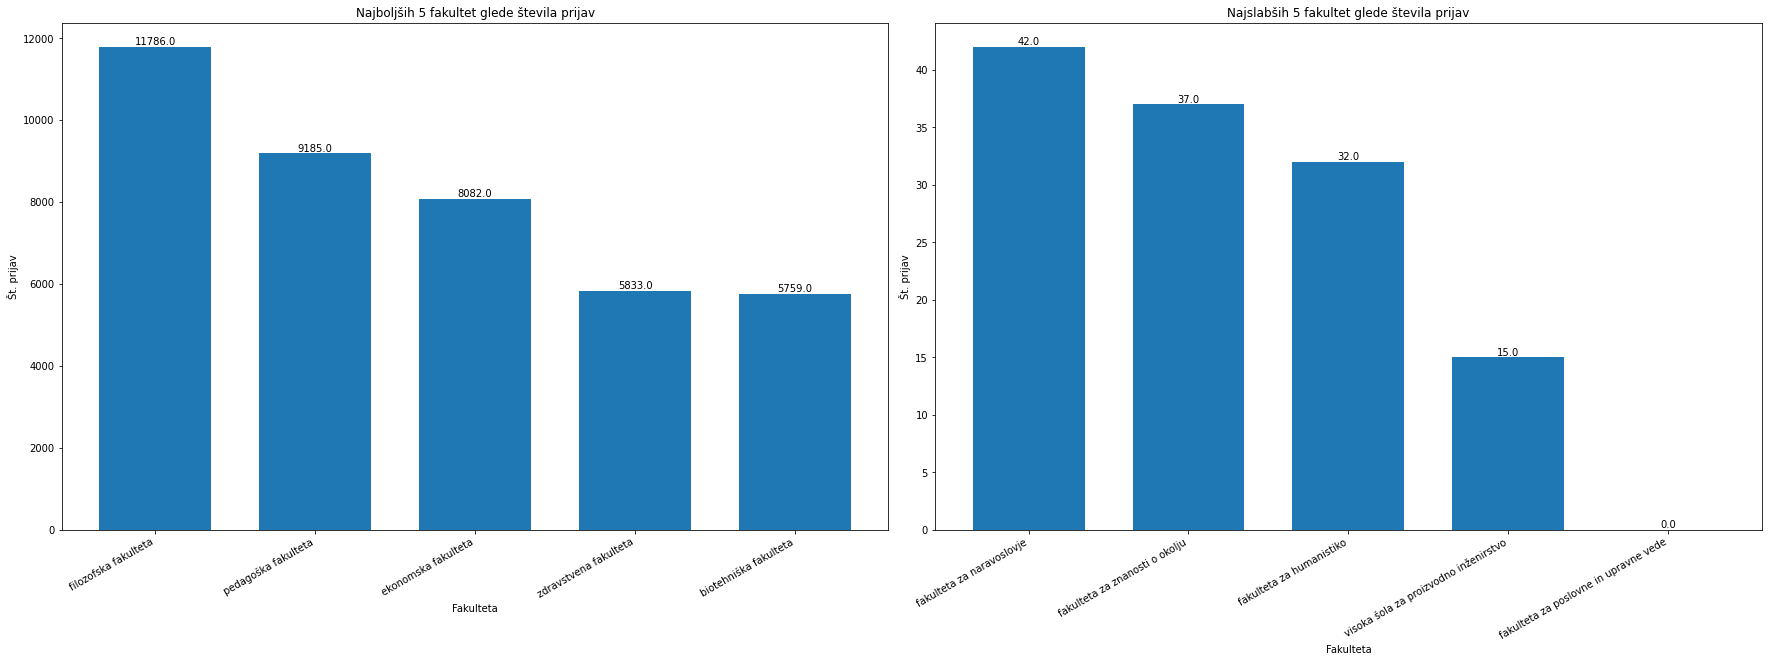

In [ ]:
df_grouped = df.groupby('fakulteta').sum()

# Sortiramo po količini prijav
df_grouped = df_grouped.sort_values(by='prijave', ascending=False)

df_top5 = df_grouped.head(5)
df_bottom5 = df_grouped.tail(5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

# Levi graf
axes[0].bar(df_top5.index, df_top5['prijave'], width=0.7)
axes[0].set_title('Najboljših 5 fakultet glede števila prijav')
axes[0].set_xlabel('Fakulteta')
axes[0].set_ylabel('Št. prijav')

for i, v in enumerate(df_top5['prijave']):
  axes[0].text(i, v, str(v), ha='center', va='bottom', rotation=0)

# Desni graf
axes[1].bar(df_bottom5.index, df_bottom5['prijave'], width=0.7)
axes[1].set_title('Najslabših 5 fakultet glede števila prijav')
axes[1].set_xlabel('Fakulteta')
axes[1].set_ylabel('Št. prijav')

for i, v in enumerate(df_bottom5['prijave']):
  axes[1].text(i, v, str(v), ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.setp(axes[0].get_xticklabels() + axes[1].get_xticklabels(), rotation=30, ha='right')
plt.show()

Spodaj pa še imamo zadnja dva grafa v sklopu analize, in sicer seznam 5 najbolj in najmanj popularnih fakultet glede števila razpisanih mest.

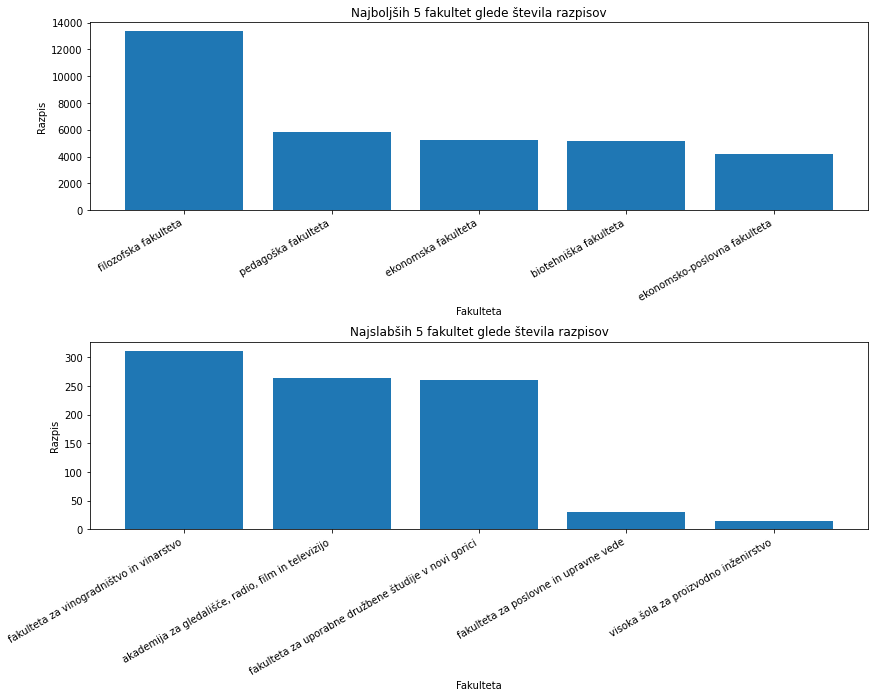

In [ ]:
df_grouped = df.groupby('fakulteta')['razpis'].sum().reset_index()
df_grouped.sort_values(by='razpis', ascending=False, inplace=True)

top_5_fakultetas = df_grouped.head(5)
bottom_5_fakultetas = df_grouped.tail(5)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Levi graf
axes[0].bar(top_5_fakultetas['fakulteta'], top_5_fakultetas['razpis'])
axes[0].set_title('Najboljših 5 fakultet glede števila razpisov')
axes[0].set_xlabel('Fakulteta')
axes[0].set_ylabel('Razpis')

# Desni graf
axes[1].bar(bottom_5_fakultetas['fakulteta'], bottom_5_fakultetas['razpis'])
axes[1].set_title('Najslabših 5 fakultet glede števila razpisov')
axes[1].set_xlabel('Fakulteta')
axes[1].set_ylabel('Razpis')

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.setp(axes[0].get_xticklabels() + axes[1].get_xticklabels(), rotation=30, ha='right')
plt.show()

df.to_excel("df_lepi_podatki.xlsx", sheet_name="df_lepi_podatki")

# 4. Strojno učenje

Sedaj pa nas čaka poglavje o strojnem učenju, vendar pa bomo sprva spoznali še nekaj dodatnega manipuliranja s podatki, da bomo lahko model pravilno naučili.


Za začetek je potrebno naložiti dataframe, ki smo ga ustvarili v preteklem poglavju.

In [ ]:
import pandas as pd

df = pd.read_excel('/content/df_lepi_podatki.xlsx', dtype = object).drop("Unnamed: 0", axis=1)

df.sort_values(['st_leto','fakulteta','program','rok'],ascending=False).head()

df.head()

,univerza,fakulteta,program,st_leto,rok,razpis,prijave,sprejeti,klasifikacija_fakultete,odstotek_sprejetih_glede_na_razpis,odstotek_sprejetih_glede_na_prijave,velikost_generacije_glede_na_prijave,velikost_generacije_glede_na_razpis,velikost_generacije_glede_na_sprejete,velikost_generacije_za_klasifikacijo_glede_na_prijave,velikost_generacije_za_klasifikacijo_glede_na_razpis,velikost_generacije_za_klasifikacijo_glede_na_sprejete
0,univerza v ljubljani,akademija za glasbo,glasbena umetnost,2021/22,1,60,152,57,Umetniska,95,37.5,29470,13514,9834,1888,604,459
1,univerza v ljubljani,akademija za glasbo,glasbena umetnost,2021/22,2,10,14,7,Umetniska,70,50,2950,4692,2080,131,191,74
2,univerza v ljubljani,akademija za glasbo,glasbena umetnost,2020/21,1,60,158,60,Umetniska,100,37.974684,13546,13481,9897,1188,590,451
3,univerza v ljubljani,akademija za glasbo,glasbena umetnost,2020/21,2,7,14,4,Umetniska,57.142857,28.571429,2999,4628,2122,161,187,82
4,univerza v ljubljani,akademija za glasbo,glasbena umetnost,2019/20,1,60,132,57,Umetniska,95,43.181818,13442,13383,9673,1074,600,426


V stolpec *program* zapišemo vrednosti za univerzo in fakulteto ter dodamo stolpec *program_id*, v katerega mapiramo unikatne vrednosti.

In [ ]:
# Kopiramo dataframe v novega za lažjo obdelavo podatkov
df_col_program = df.copy()

# Pretvorimo stolpec st_leto v lažje berljivi format z eno letnico
df_col_program['st_leto'] = df_col_program['st_leto'].apply(lambda x: int(x.split('/')[1]))

df_col_program = df_col_program.sort_values(by=['univerza','fakulteta','program','st_leto','rok'])

# V stolpec 'program' zapišemo 'program + fakulteta + univerza', da lažje razberemo unikatne vrednosti
df_col_program['program'] = df_col_program['program'] + " (" + df_col_program['fakulteta'] + ")" + " (" + df_col_program['univerza'] + ")"
df_col_program = df_col_program.drop(columns=['fakulteta', 'univerza'])

# V stolpcu program_id mapiramo ustrezen števec od 1 dalje
programs = df_col_program['program'].unique()
program_map = {program: i+1 for i, program in enumerate(programs)}
df_col_program['program_id'] = df_col_program['program'].map(program_map)

df_col_program.to_excel("df_program_values.xlsx", sheet_name="df_lol rows")

# Spremenimo stolpec 'klasifikacija_fakultete' v stolpce primerne za strojno učenje
df_col_program = pd.get_dummies(df_col_program, columns=['klasifikacija_fakultete'], prefix='klasifikacija_fakultete')
df_col_program.columns = df_col_program.columns.str.lower()

df_1 = df_col_program.copy()
print(df_1.columns)

Index(['program', 'st_leto', 'rok', 'razpis', 'prijave', 'sprejeti',
       'odstotek_sprejetih_glede_na_razpis',
       'odstotek_sprejetih_glede_na_prijave',
       'velikost_generacije_glede_na_prijave',
       'velikost_generacije_glede_na_razpis',
       'velikost_generacije_glede_na_sprejete',
       'velikost_generacije_za_klasifikacijo_glede_na_prijave',
       'velikost_generacije_za_klasifikacijo_glede_na_razpis',
       'velikost_generacije_za_klasifikacijo_glede_na_sprejete', 'program_id',
       'klasifikacija_fakultete_druzboslovna',
       'klasifikacija_fakultete_naravoslovna',
       'klasifikacija_fakultete_tehniska', 'klasifikacija_fakultete_umetniska',
       'klasifikacija_fakultete_zdravstvena'],
      dtype='object')


Obstoječo podatkovno množico ločimo po unikatnih programih in po roku ter jim dodelimo ustrezne tipe stolpcev. Dodatno jih še preimenujemo v *feature_program_id_rok*, zato da bomo lažje napovedovali vrednosti v prihodnje. Na koncu nam še preostane zgolj shranjevanje v novo množico.

In [ ]:
df_unikatni_programi_roki = pd.DataFrame()

# Ločimo podatkovno množico na več dataframeov glede na unikatne programe,
# vsak nastali df še dodatno ločimo po roku
grouped = df_1.groupby('program')
for program, group in grouped:
    unikatni_roki = group['rok'].unique()    
    for rok in unikatni_roki:
        program_rok_df = group[group['rok'] == rok]

        # Dodelitev primernih tipov v stolpce
        program_rok_df.drop(['program'], axis=1, inplace=True)
        program_rok_df['st_leto'] = program_rok_df['st_leto'].astype('int64')
        program_rok_df['rok'] = program_rok_df['rok'].astype('int64')
        program_rok_df['program_id'] = program_rok_df['program_id'].astype('int64')
        program_rok_df['klasifikacija_fakultete_druzboslovna'] = program_rok_df['klasifikacija_fakultete_druzboslovna'].astype('boolean')
        program_rok_df['klasifikacija_fakultete_naravoslovna'] = program_rok_df['klasifikacija_fakultete_naravoslovna'].astype('boolean')
        program_rok_df['klasifikacija_fakultete_tehniska'] = program_rok_df['klasifikacija_fakultete_tehniska'].astype('boolean')
        program_rok_df['klasifikacija_fakultete_umetniska'] = program_rok_df['klasifikacija_fakultete_umetniska'].astype('boolean')
        program_rok_df['klasifikacija_fakultete_zdravstvena'] = program_rok_df['klasifikacija_fakultete_zdravstvena'].astype('boolean')

        # V df-ju preimenujemo stolpce (npr. feature__program_id__rok)
        cols = program_rok_df.columns
        new_cols = [col + '_' + str(program_rok_df['program_id'].iloc[0]) + '_' + str(program_rok_df['rok'].iloc[0]) if col not in ['st_leto'] else col for col in cols]
        program_rok_df.columns = new_cols

        # Zapišem v nov dataframe te podatke
        if df_unikatni_programi_roki.empty:
            df_unikatni_programi_roki = program_rok_df.copy()
        else:
            df_unikatni_programi_roki = pd.merge(df_unikatni_programi_roki, program_rok_df, on='st_leto', how='outer', suffixes=('', '_suffix'))

Pridobljeno podatkovno množico še dopolnemo s sortiranjem vrednosti po letu padajoče, manjkajočim vrednostim pa z *MinMaxScaler* dodelimo povprečne vrednosti.

Za napoved uporabimo vrednosti razpisov za aktualno leto, tako da teh ne odstranimo, saj bo model tako boljši. V našem primeru bomo obdržali vse nezamaknjene vrstice in dodali zamaknjene razpise (vrednosti, ki jih bomo napovedovali). Z drugimi besedami kloniramo stolpce razpisov pod novimi imeni npr. *razpis_id_programa _napovedovan* in samo te nove stolpce zamaknemo s *shift()* metodo.

Naš naučen model bo sedaj znal napovedati vse vrednosti razpisov v enem mahu na podlagi naučenega modela, ki se uči iz vrednosti prejšnjega leta.

In [ ]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler

# Sortiramo vrednosti po 'st_leto' padajoče
df_unikatni_programi_roki.sort_values(by='st_leto', ascending=False, inplace=True)

# Manjkajočim vrednostim dodelimo povprečne vrednosti
scaler = MinMaxScaler()
df_unikatni_programi_roki.fillna(df_unikatni_programi_roki.mean(), inplace=True)
df_unikatni_programi_roki.to_excel("df_neshiftani_podatki.xlsx", sheet_name="df_neshiftani_podatki rows")

# Poiščemo novo nastale stolpce, ki vsebujejo 'feature_' podatke za napoved razpisa
cols = df_unikatni_programi_roki.columns
razpis_cols = [col for col in cols if col.startswith("razpis")]

# Dupliciramo stolpce v 'razpis_df'
razpis_df = df_unikatni_programi_roki[razpis_cols].copy()
razpis_df.rename(columns={col: "feature_" + col for col in razpis_df.columns}, inplace=True)

# Dodamo spremenjene stolpce v originalni df_unikatni_programi_roki
df_unikatni_programi_roki = pd.concat([df_unikatni_programi_roki, razpis_df], axis=1)

# shiftamo stolpce iz razpis_df v df_unikatni_programi_roki
df_unikatni_programi_roki[razpis_df.columns] = df_unikatni_programi_roki[razpis_df.columns].shift(1)

df_unikatni_programi_roki.to_excel("df_shiftani_podatki.xlsx", sheet_name="df_shiftani_podatki")

# 4.5 Izvedba strojnega učenja

Sedaj pa nas končno pričaka izvedba samega strojnega učenja.

Potrebne knjižnjice za bodoče napovedi:

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

df_unshifted = pd.read_excel('/content/df_neshiftani_podatki.xlsx', dtype = object).drop("Unnamed: 0", axis=1)
df_shifted = pd.read_excel('/content/df_shiftani_podatki.xlsx', dtype = object).drop("Unnamed: 0", axis=1)

Sedaj je potrebna delitev množice na učno in testno. Ena vrstica se razdeli v X, ki vključuje vse feature brez napovedanih razpisov, y pa vsebuje vse napovedane razpise. V praksi to namreč pomeni, da napovedujemo iz vseh vrednosti prejšnjega leta ter dobimo vse razpise za prihodnje leto.  

In [ ]:
df_shifted.dropna(inplace=True)
df_unshifted = df_unshifted.drop(0)

# Razdelimo podatke na trenirano in testno množico
X = df_unshifted
y = df_shifted

X.info()
y.info()

# Iz shifted množice odstranimo vse stolpce, ki se nahajajo v neshifted
cols_to_drop = y.columns[y.columns.isin(X.columns)]
y.drop(columns=cols_to_drop, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1 to 5
Columns: 10351 entries, st_leto to klasifikacija_fakultete_zdravstvena_232_2
dtypes: object(10351)
memory usage: 404.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1 to 5
Columns: 10926 entries, st_leto to feature_razpis_232_2
dtypes: object(10926)
memory usage: 426.8+ KB


Prikaz trenirane množice.

In [ ]:
X.head()

,st_leto,rok_226_1,razpis_226_1,prijave_226_1,sprejeti_226_1,odstotek_sprejetih_glede_na_razpis_226_1,odstotek_sprejetih_glede_na_prijave_226_1,velikost_generacije_glede_na_prijave_226_1,velikost_generacije_glede_na_razpis_226_1,velikost_generacije_glede_na_sprejete_226_1,...,velikost_generacije_glede_na_sprejete_232_2,velikost_generacije_za_klasifikacijo_glede_na_prijave_232_2,velikost_generacije_za_klasifikacijo_glede_na_razpis_232_2,velikost_generacije_za_klasifikacijo_glede_na_sprejete_232_2,program_id_232_2,klasifikacija_fakultete_druzboslovna_232_2,klasifikacija_fakultete_naravoslovna_232_2,klasifikacija_fakultete_tehniska_232_2,klasifikacija_fakultete_umetniska_232_2,klasifikacija_fakultete_zdravstvena_232_2
1,21,1,20,8,10,50,125,13546,13481,9897,...,2122,780,1699,595,232,False,True,False,False,False
2,20,1,25,13,13,52,100,13442,13383,9673,...,2192,845,1664,606,232,False,True,False,False,False
3,19,1,25,2,2,8,100,13417,13388,9580,...,2332,784,1795,680,232,False,True,False,False,False
4,18,1,40,2,2,5,100,12921,13367,9340,...,2540,877,1702,737,232,False,True,False,False,False
5,17,1,40,7,4,10,57.142857,13380,13199,9560,...,2238,805,1566,672,232,False,True,False,False,False


Prikaz testne množice.

In [ ]:
y.head()

,feature_razpis_226_1,feature_razpis_226_2,feature_razpis_227_1,feature_razpis_227_2,feature_razpis_228_1,feature_razpis_228_2,feature_razpis_264_1,feature_razpis_264_2,feature_razpis_132_1,feature_razpis_133_1,...,feature_razpis_130_1,feature_razpis_130_2,feature_razpis_131_1,feature_razpis_131_2,feature_razpis_285_1,feature_razpis_285_2,feature_razpis_80_1,feature_razpis_80_2,feature_razpis_232_1,feature_razpis_232_2
1,20,11,20,18,20,14,45,25,85,12,...,50,11,30,15,35,21,70,4,30,15
2,20,10,20,9,20,14,40,5,75,12,...,50,14,30,14,35,14,70,6,30,20
3,25,14,30,23,30,19,40,6,75,12,...,50,21,30,14,35,16,70,4,35,15
4,25,23,30,26,30,21,40,4,75,12,...,50,19,30,17,45,26,70,4,35,21
5,40,38,35,24,40,26,40,5,75,12,...,50,21,30,19,45,31,70,4,35,13


V modelu s pomočjo linearne regresije napovedmo spremenljivko odziva (y_train) na podlagi množice napovedovalca (X_train).

In [ ]:
# Ustvarimo cevovod, ki preoblikuje podatke in ustreza modelu linearne regresije
reg = LinearRegression()

model=reg.fit(X_train, y_train)

# Napovemo za eno leto več kot je napisano pod st_leto
predicted= model.predict(X_test)
X_test.head()

,st_leto,rok_226_1,razpis_226_1,prijave_226_1,sprejeti_226_1,odstotek_sprejetih_glede_na_razpis_226_1,odstotek_sprejetih_glede_na_prijave_226_1,velikost_generacije_glede_na_prijave_226_1,velikost_generacije_glede_na_razpis_226_1,velikost_generacije_glede_na_sprejete_226_1,...,velikost_generacije_glede_na_sprejete_232_2,velikost_generacije_za_klasifikacijo_glede_na_prijave_232_2,velikost_generacije_za_klasifikacijo_glede_na_razpis_232_2,velikost_generacije_za_klasifikacijo_glede_na_sprejete_232_2,program_id_232_2,klasifikacija_fakultete_druzboslovna_232_2,klasifikacija_fakultete_naravoslovna_232_2,klasifikacija_fakultete_tehniska_232_2,klasifikacija_fakultete_umetniska_232_2,klasifikacija_fakultete_zdravstvena_232_2
3,19,1,25,2,2,8,100,13417,13388,9580,...,2332,784,1795,680,232,False,True,False,False,False
1,21,1,20,8,10,50,125,13546,13481,9897,...,2122,780,1699,595,232,False,True,False,False,False


Prikaz napovedanih vrstic za leto 19 (vrstica z indeksom 0) in leto 21 (vrstica z indeksom 1).

In [ ]:
df_napoved = pd.DataFrame(predicted, columns=y.columns)

df_napoved.head()

,feature_razpis_226_1,feature_razpis_226_2,feature_razpis_227_1,feature_razpis_227_2,feature_razpis_228_1,feature_razpis_228_2,feature_razpis_264_1,feature_razpis_264_2,feature_razpis_132_1,feature_razpis_133_1,...,feature_razpis_130_1,feature_razpis_130_2,feature_razpis_131_1,feature_razpis_131_2,feature_razpis_285_1,feature_razpis_285_2,feature_razpis_80_1,feature_razpis_80_2,feature_razpis_232_1,feature_razpis_232_2
0,24.828924,18.102899,25.008763,15.576125,25.942247,17.782741,40.0,4.778567,75.0,12.0,...,50.0,16.412408,30.0,15.602509,39.074706,19.837571,70.0,5.184514,32.052537,18.922205
1,20.902998,10.691541,19.918051,8.267599,20.348580,14.022163,40.0,5.128668,75.0,12.0,...,50.0,13.935825,30.0,14.112768,34.479250,14.014081,70.0,6.096292,29.958830,19.379021


S pomočjo knjižnjice math smo izračunali tudi splošno natančnost našega modela:
* Z matriko MAE prikazujemo povprečno absolutno napako med dejanskimi vrednostmi v 'y_test' in predvidenimi vrednostmi 'df_napoved'.
* Z matriko MSE prikazujemo srednjo kvadratno napako med dejanskimi vrednostmi v 'y_test' in predvidenimi vrednostmi 'df_napoved'.
* Z matriko RMSE srednjo kvadratno napako med dejanskimi vrednostmi v 'y_test' in predvidenimi vrednostmi 'df_napoved', ki pa je kvadratni koren MSE.

In [ ]:
import math

print('MAE:', metrics.mean_absolute_error(df_napoved, y_test))

print('MSE:', metrics.mean_squared_error(df_napoved, y_test))

print('RMSE:', math.sqrt(metrics.mean_squared_error(df_napoved, y_test)))

MAE: 2.6196902380089284
MSE: 29.93141525512898
RMSE: 5.470961090624661


Preostane nam analiza nad starimi in napovedanimi podatki, zato bomo naložili podatke in pogledali spremembe.
Ugotovili smo, da je napovedana velikost generacije za leto 21 velika kar 18424 študentov, dejanska generacija pa je bila velika 18206 študentov.

In [ ]:
# Obdržimo zadnjo napoved
df_napoved_22 = df_napoved.iloc[-1:]

# Velikost napovedane generacije
df_sum_napovedi = df_napoved_22.sum().sum()
print("Napovedana velikost generacije:", df_sum_napovedi)

# Pregledamo razpise za originalne podatke
df_old_data = pd.read_excel('/content/df_program_values.xlsx', dtype = object).drop("Unnamed: 0", axis=1)
df_selected = df_old_data[df_old_data['st_leto'] == 22]

sum_of_razpis = df_selected['razpis'].sum()

print("Velikost dejanske generacije:", sum_of_razpis)

Napovedana velikost generacije: 18424.379000792822
Velikost dejanske generacije: 18206


V sledeči razpredelnici pa lahko opazimo mapirane vrednosti razpisov s program_id.

In [ ]:
df_test = pd.DataFrame(columns=['program_id', 'razpis'])

for column in df_napoved_22.columns:
  
  # Razdelimo ime stolpca s '_' in pridobimo vrednost
  first_number = column.split("_")[2]
  
  # Dodelimo vrednost v stolpec program_id in pripišemo vrednost razpisa
  df_test = df_test.append({'program_id': first_number, 'razpis': df_napoved_22[column].values[0]}, ignore_index=True)

df_test.head()

,program_id,razpis
0,226,20.902998
1,226,10.691541
2,227,19.918051
3,227,8.267599
4,228,20.348580


Ker želimo sestaviti tabelo z dejanskimi programi, bo potrebno mapirati še to vrednost.

In [ ]:
df_test['program_id'] = df_test['program_id'].astype('int64')
df_selected['program_id'] = df_selected['program_id'].astype('int64')

df_test = df_selected.merge(df_test[['program_id', 'razpis']], on='program_id', how='left')
df_test = df_test.drop(columns=['razpis_x'])

df_test.rename(columns={'razpis_y': 'razpis'}, inplace=True)
df_test.drop_duplicates(subset=['razpis', 'program_id'], inplace=True)

df_test.to_excel("df_test.xlsx", sheet_name="df_test rows")

df_test = df_test[['program_id', 'program', 'razpis', 'st_leto']]

df_test.head()

<ipython-input-39-a926d8c2427c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['program_id'] = df_selected['program_id'].astype('int64')


,program_id,program,razpis,st_leto
0,1,pravo (evropska pravna fakulteta) (nova univerza),67.616260,22
1,1,pravo (evropska pravna fakulteta) (nova univerza),40.167829,22
4,2,javna uprava (fakulteta za državne in evropske...,58.262564,22
5,2,javna uprava (fakulteta za državne in evropske...,54.112569,22
8,3,dizajn - notranja oprema (fakulteta za dizajn)...,30.000000,22


Sedaj pa še pogledamo kako izgledajo naši stari podatki za razpise.

In [ ]:
df_napovedani = pd.read_excel('/content/df_test.xlsx', dtype = object).drop("Unnamed: 0", axis=1)
df_napovedani['rok'] = df_napovedani.groupby('program_id').cumcount() + 1
df_stari = df_selected[['program','program_id','rok','razpis']]
df_napovedani = df_napovedani[['program_id', 'program', 'razpis', 'st_leto']]

df_stari.head() 

,program,program_id,rok,razpis
10,pravo (evropska pravna fakulteta) (nova univerza),1,1,68
11,pravo (evropska pravna fakulteta) (nova univerza),1,2,36
22,javna uprava (fakulteta za državne in evropske...,2,1,59
23,javna uprava (fakulteta za državne in evropske...,2,2,55
34,dizajn - notranja oprema (fakulteta za dizajn)...,3,1,30


# 5. Predstavitev rezultatov

Sedaj pa bomo v zadnjem poglavju predstavili grafa, ki smo ju naredili s pomočjo vseh zbranih podatkov in obstoječih analiz.

Napovedane in obstoječe podatke za leto 2021 smo združili v en dataframe in izračunali razliko med razpisom ter grupirali podatke po programu. Spodaj je v obsežnem grafu prikazana razlika med dejanskimi in napovedanimi mesti. Kot lahko opazimo, je ta razlika minimalna in dejansko prikazuje uspešnost našega modela.

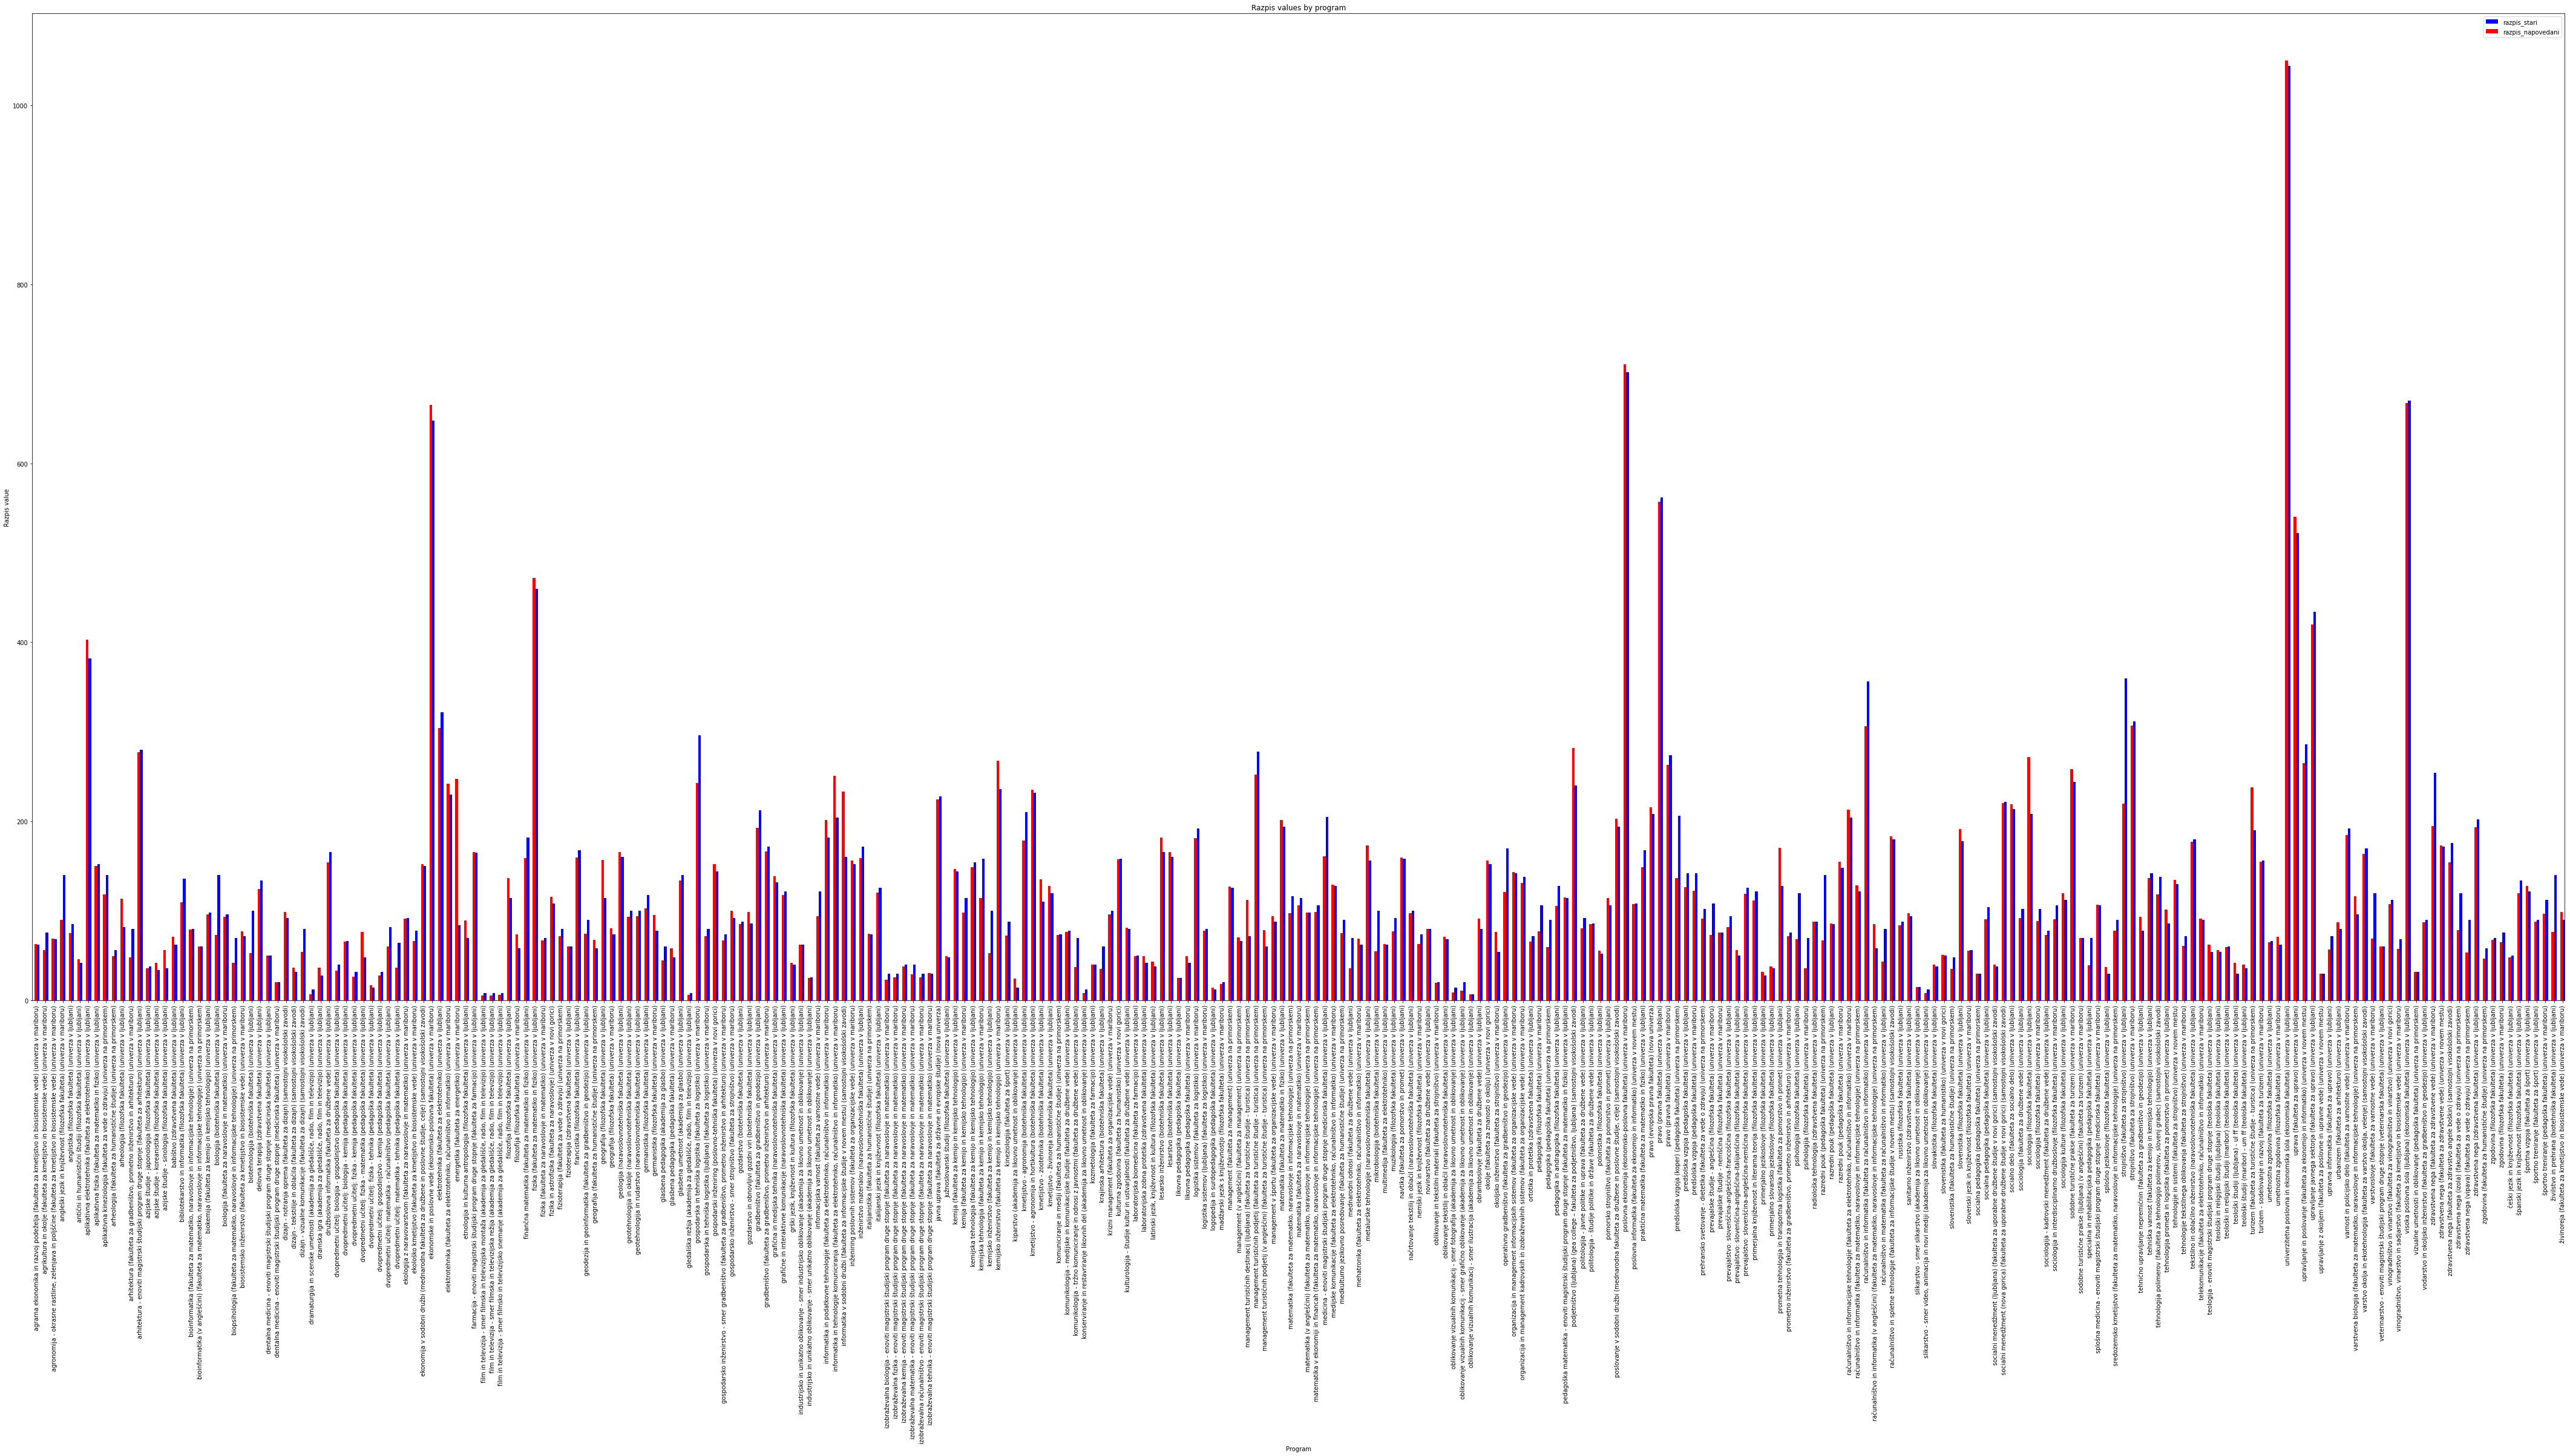

Število programov: 1051


In [ ]:
from matplotlib import pyplot as plt

# Združimo oba dataframe-a
df = pd.merge(df_stari, df_napovedani, on=['program_id', 'program'], suffixes=('_stari', '_napovedani'))

# Izračunamo razliko med razpisom za df_stari in df_napovedani
df['difference'] = df['razpis_napovedani'] - df['razpis_stari']

# Grupiramo podatke po programu
grouped = df.groupby('program')

plt.figure(figsize=(75,30))

# Izrišemo 'razpis_stari' in 'razpis_napovedani' vrednosti v stolpičnem grafu
grouped['razpis_stari'].sum().plot(kind='bar', color='blue', width=0.3, position=0, legend=True)
grouped['razpis_napovedani'].sum().plot(kind='bar', color='red', width=0.3, position=1, legend=True)

plt.title("Razpis values by program")
plt.xlabel("Program")
plt.ylabel("Razpis value")

plt.show()

print('Število programov:', df.shape[0])

Zanima nas pa tudi uspešnost programov, ki so bili napovedani s 100% natančnostjo. Rezultat smo pridobili tako, da smo filtrirali združeni dataframe tako, da vključuje vrstice, kjer je razlika enaka vrednosti 0. Nato pa smo še pogrupirali po programu ter izračunali razliko za razpis_stari in razpis_napovedani.

Ugotovili smo, da je model natančno napovedal kar 201 programov, kar v praksi pomeni petino vseh podatkov.

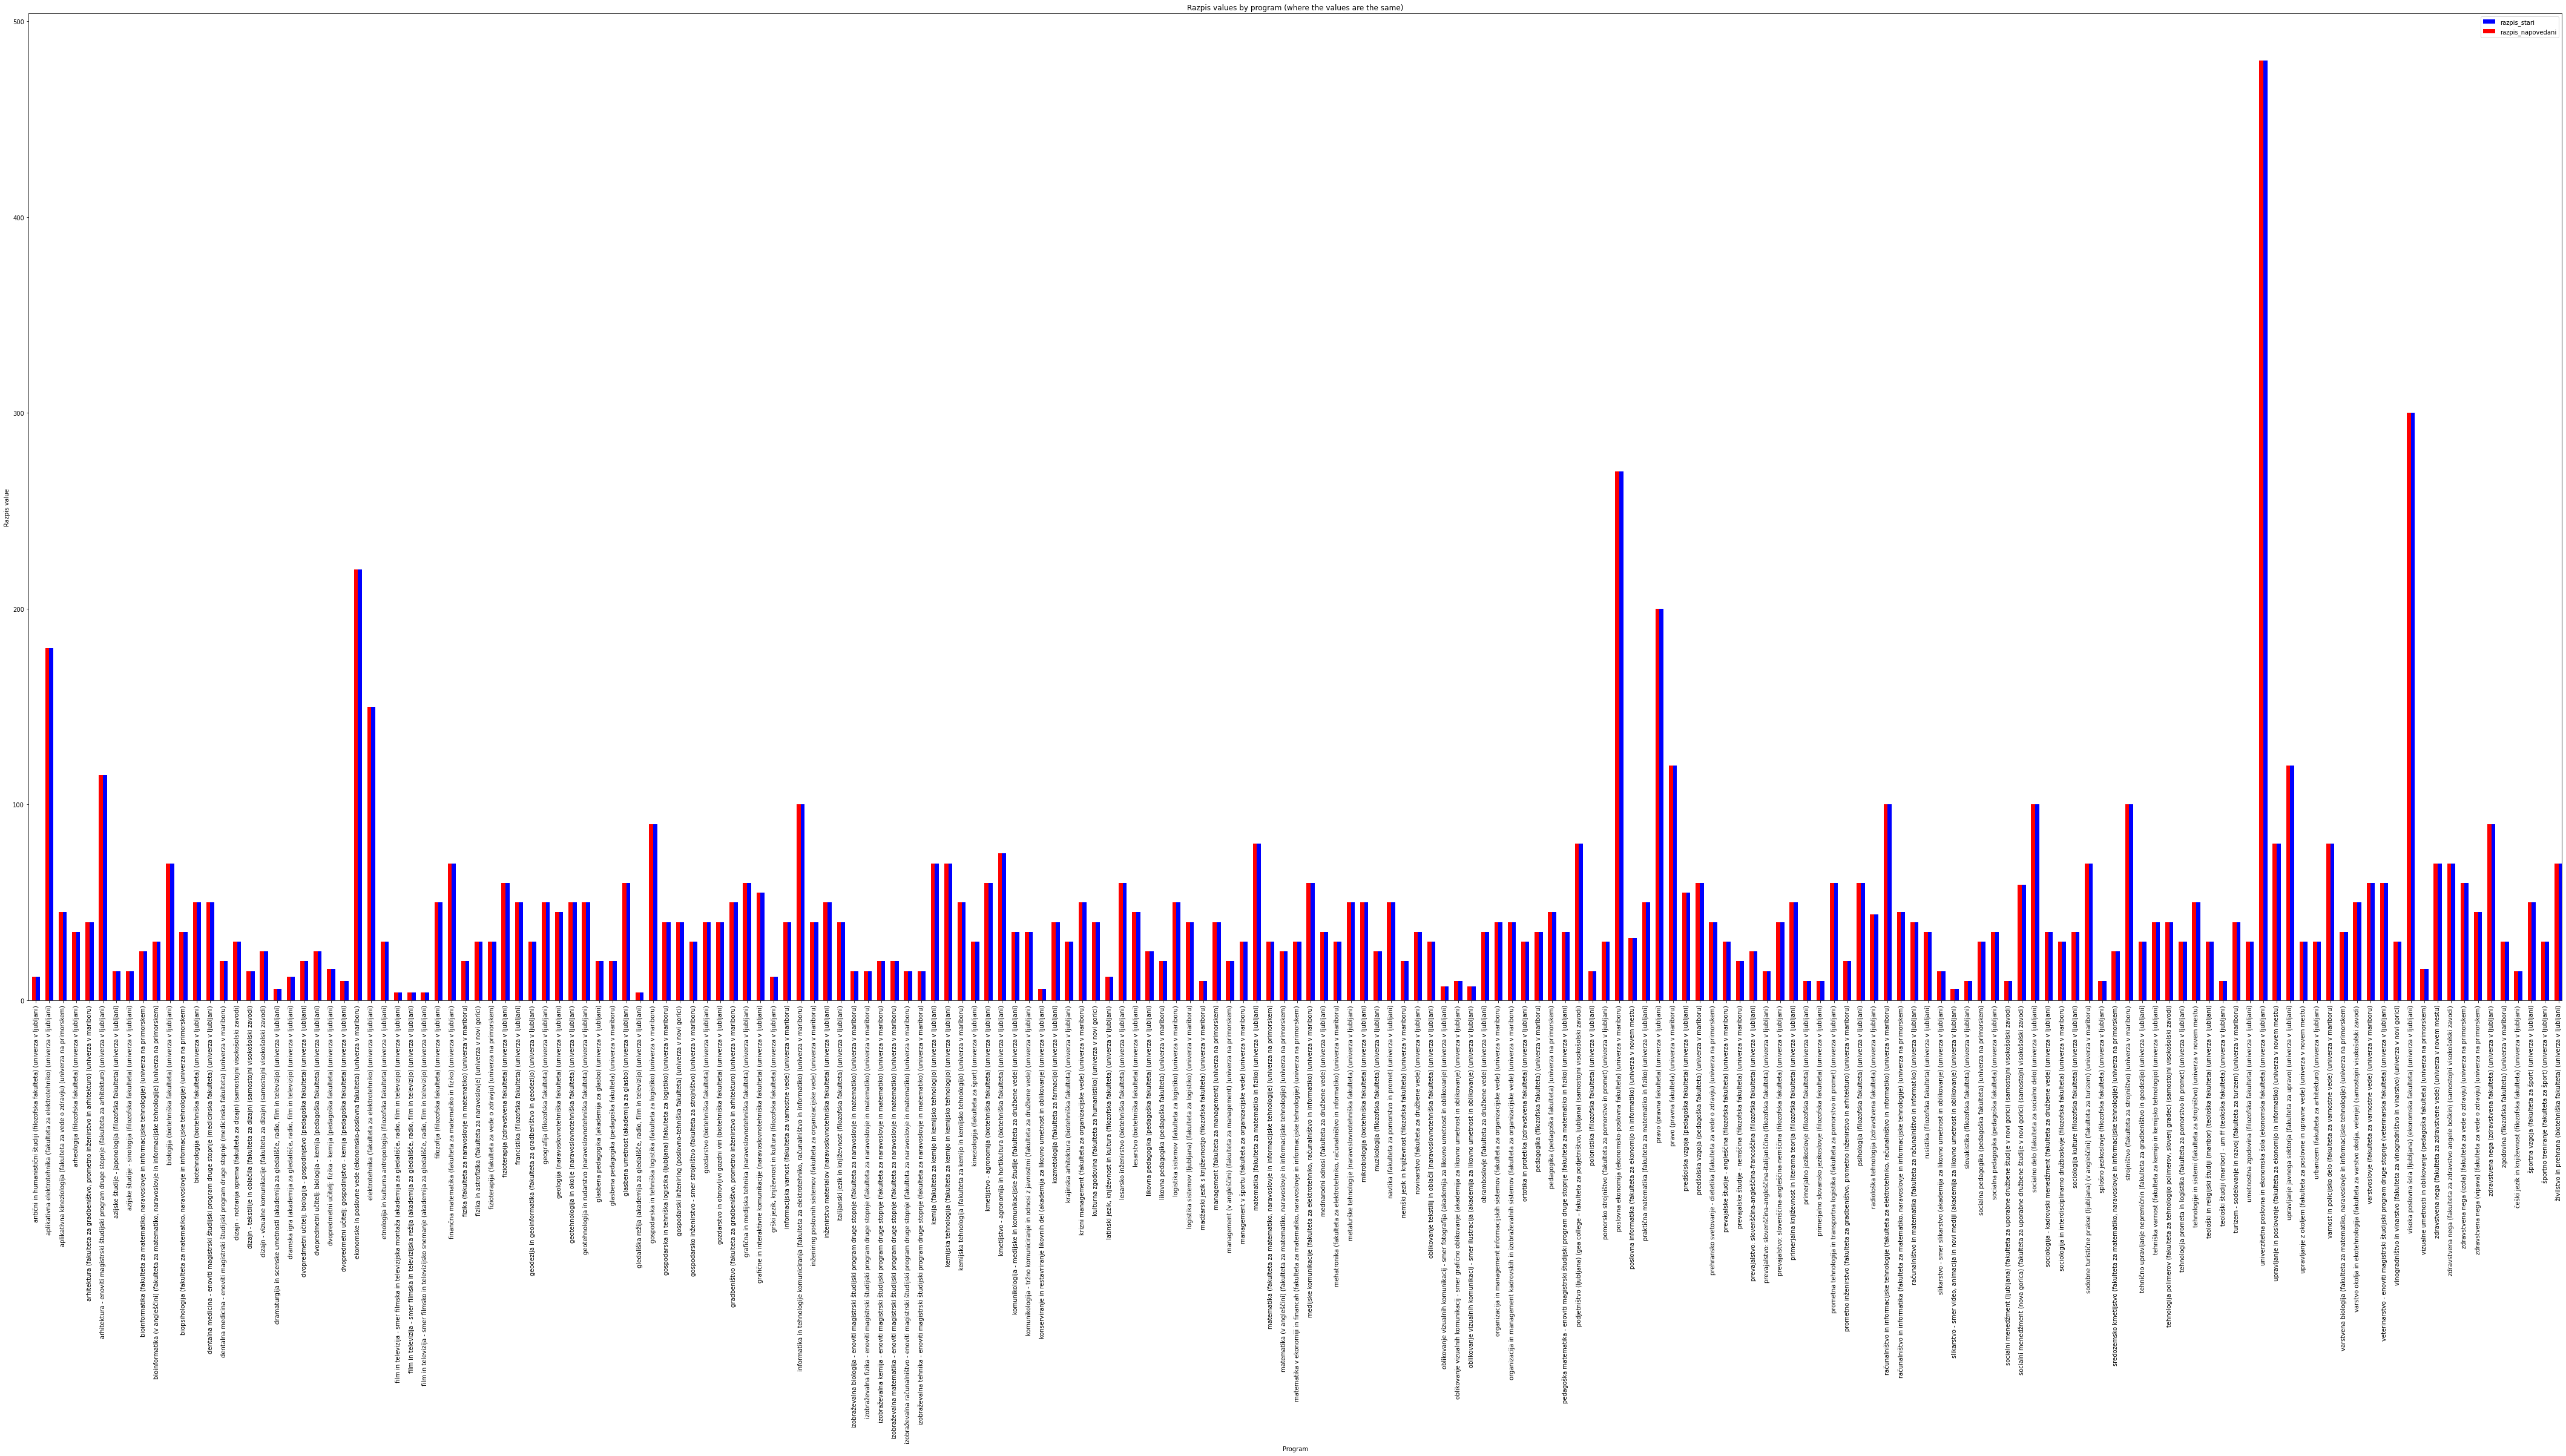

Count: 201
Število pravilno napovedanih: 5.2288557213930345


In [ ]:
# Filtriramo združeni podatkovni okvir, da vključimo samo vrstice, kjer je razlika enaka 0
df_same = df[df['difference'] == 0]

# Grupiramo podatke po programu
grouped = df_same.groupby('program')

plt.figure(figsize=(75,30))

# Izračunamo razliko med razpisom za razpis_stari in razpis_napovedani
grouped['razpis_stari'].sum().plot(kind='bar', color='blue', width=0.3, position=0, legend=True)
grouped['razpis_napovedani'].sum().plot(kind='bar', color='red', width=0.3, position=1, legend=True)

plt.title("Razpis values by program (where the values are the same)")
plt.xlabel("Program")
plt.ylabel("Razpis value")

plt.show()

print('Count:', df_same.shape[0])
print('Število pravilno napovedanih:', (df.shape[0] / df_same.shape[0]))

# 6. Zaključne misli

Povzamemo lahko, da smo skozi celoten projekt spoznali predvsem zanimivo strukturo podatkov preko portala *Dijaški.net*. Ugotovili smo, da imamo na slovenskem predvsem prevladujočo *družboslovno smer*, ki pa je posledica centralizacije fakultet v osrčju države, *Ljubljani*. Vsaka generacija je predvsem zelo podobna ostalim po *razpisih*, *sprejetih študentih*, glede vpisnih mest pa je izstopajoča *2021/22* generacija. Spoznali smo tudi, da lahko s strojnim učenjem izredno dobro naučimo model, da bo z visoko natančnostjo znal napovedati število razpisov v bodočih generacijah. V prihodnjosti bi se še lahko lotili tematike glede omejitev na fakultetah, vendar pa bo za to potrebna pridobitev kakovostnih in celotivih podatkov.